In [9]:
%matplotlib inline
import backtrader as bt
import backtrader.feeds as btfeeds
import matplotlib.pyplot as plt
import pyfolio as pf
# import matplotlib
# matplotlib.use('Qt5Agg')
# plt.switch_backend('Qt5Agg')


# Create a Stratey
class SMAStrategy(bt.Strategy):
    params = (('pfast',101),('pslow',321),)


    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        self.order = None

        self.slow_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pslow)
        self.fast_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pfast)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None


    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # We are not in the market, look for a signal to OPEN trades
                
            #If the 20 SMA is above the 50 SMA
            if self.fast_sma[0] > self.slow_sma[0] and self.fast_sma[-1] < self.slow_sma[-1]:
                self.log(f'BUY CREATE {self.dataclose[0]:2f}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(exectype=bt.Order.Close, size=self.broker.getcash() // self.dataclose[0])

        else:
            
            # We are already in the market, look for a signal to CLOSE trades
            if self.fast_sma[0] < self.slow_sma[0] and self.fast_sma[-1] > self.slow_sma[-1]:
                self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.order = self.close()



data = btfeeds.YahooFinanceCSVData(dataname='datasets/backtrader/SPY.csv')

cerebro = bt.Cerebro()


cerebro.adddata(data)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='posval', cash=True)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='ret')

cerebro.addstrategy(SMAStrategy)
cerebro.broker.setcash(5000.0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

strats = cerebro.run()
strat0 = strats[0]
pyfoliozer = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

print('Sharpe Ratio:', strat0.analyzers.mysharpe.get_analysis())
# print('Sharpe Ratio:', strat0.analyzers.posval.get_analysis())
# trades =  strat0.analyzers.trades.get_analysis()


# for key, value in trades.items():
#     print(key, value)

Starting Portfolio Value: 5000.00
1994-08-26 BUY CREATE 28.190000
1994-08-29 BUY EXECUTED, 28.18
2001-01-02 CLOSE CREATE 84.660000
2001-01-03 SELL EXECUTED, 84.33
2003-07-18 BUY CREATE 67.810000
2003-07-21 BUY EXECUTED, 66.97
2008-02-27 CLOSE CREATE 102.190000
2008-02-28 SELL EXECUTED, 101.47
2009-09-30 BUY CREATE 81.360000
2009-10-01 BUY EXECUTED, 79.34
2011-11-11 CLOSE CREATE 101.500000
2011-11-14 SELL EXECUTED, 101.12
2012-02-23 BUY CREATE 110.180000
2012-02-24 Order Canceled/Margin/Rejected
2016-06-20 BUY CREATE 183.780000
2016-06-21 Order Canceled/Margin/Rejected
2019-04-29 BUY CREATE 274.080000
2019-04-30 BUY EXECUTED, 274.22
2020-06-16 CLOSE CREATE 297.850000
2020-06-17 SELL EXECUTED, 298.90
2020-08-12 BUY CREATE 322.560000
2020-08-13 BUY EXECUTED, 321.98
2022-06-07 CLOSE CREATE 407.300000
2022-06-08 SELL EXECUTED, 405.53
2023-05-15 BUY CREATE 411.480000
2023-05-16 BUY EXECUTED, 408.73
Final Portfolio Value: 42395.35
Sharpe Ratio: OrderedDict([('sharperatio', 0.5527995376196067)

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.51,2020-02-19,2020-03-23,2020-11-16,194
1,19.19,2018-09-20,2018-12-24,2019-11-08,297
2,18.09,2022-01-03,2022-05-19,NaT,NaN
3,11.86,2015-07-20,2015-08-25,2016-07-14,259
4,10.02,2018-01-26,2018-02-08,2018-08-06,137


c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\timeseries.py:1227: FutureWarning: Indexing a timezone

Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehman,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,-0.01%,-1.06%,1.51%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


Top 10 long positions of all time,max
SPY,99.63%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,99.63%


c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\plotting.py:1546: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\plotting.py:1626: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  txn_time = txn_time.groupby(level=0).sum().reindex(index=range(570, 961))
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\pyfolio\round_trips.py:304: 

KeyError: ('block_dir', 'block_time')

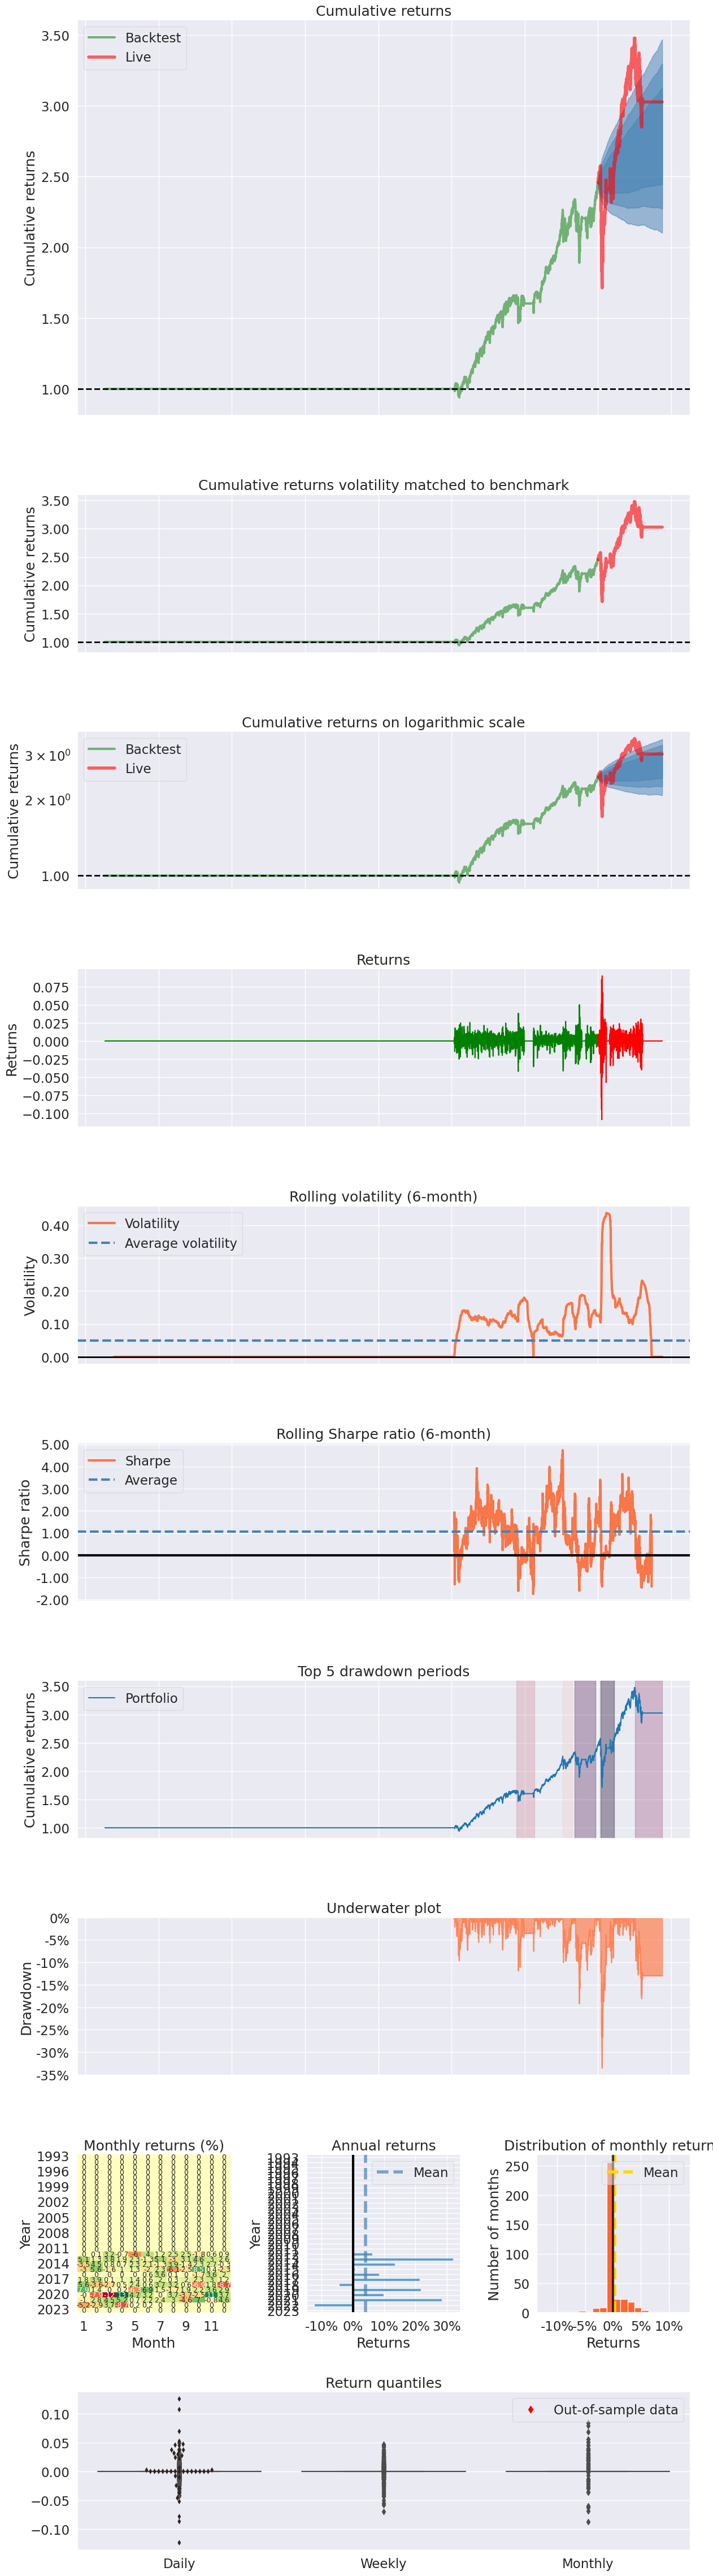

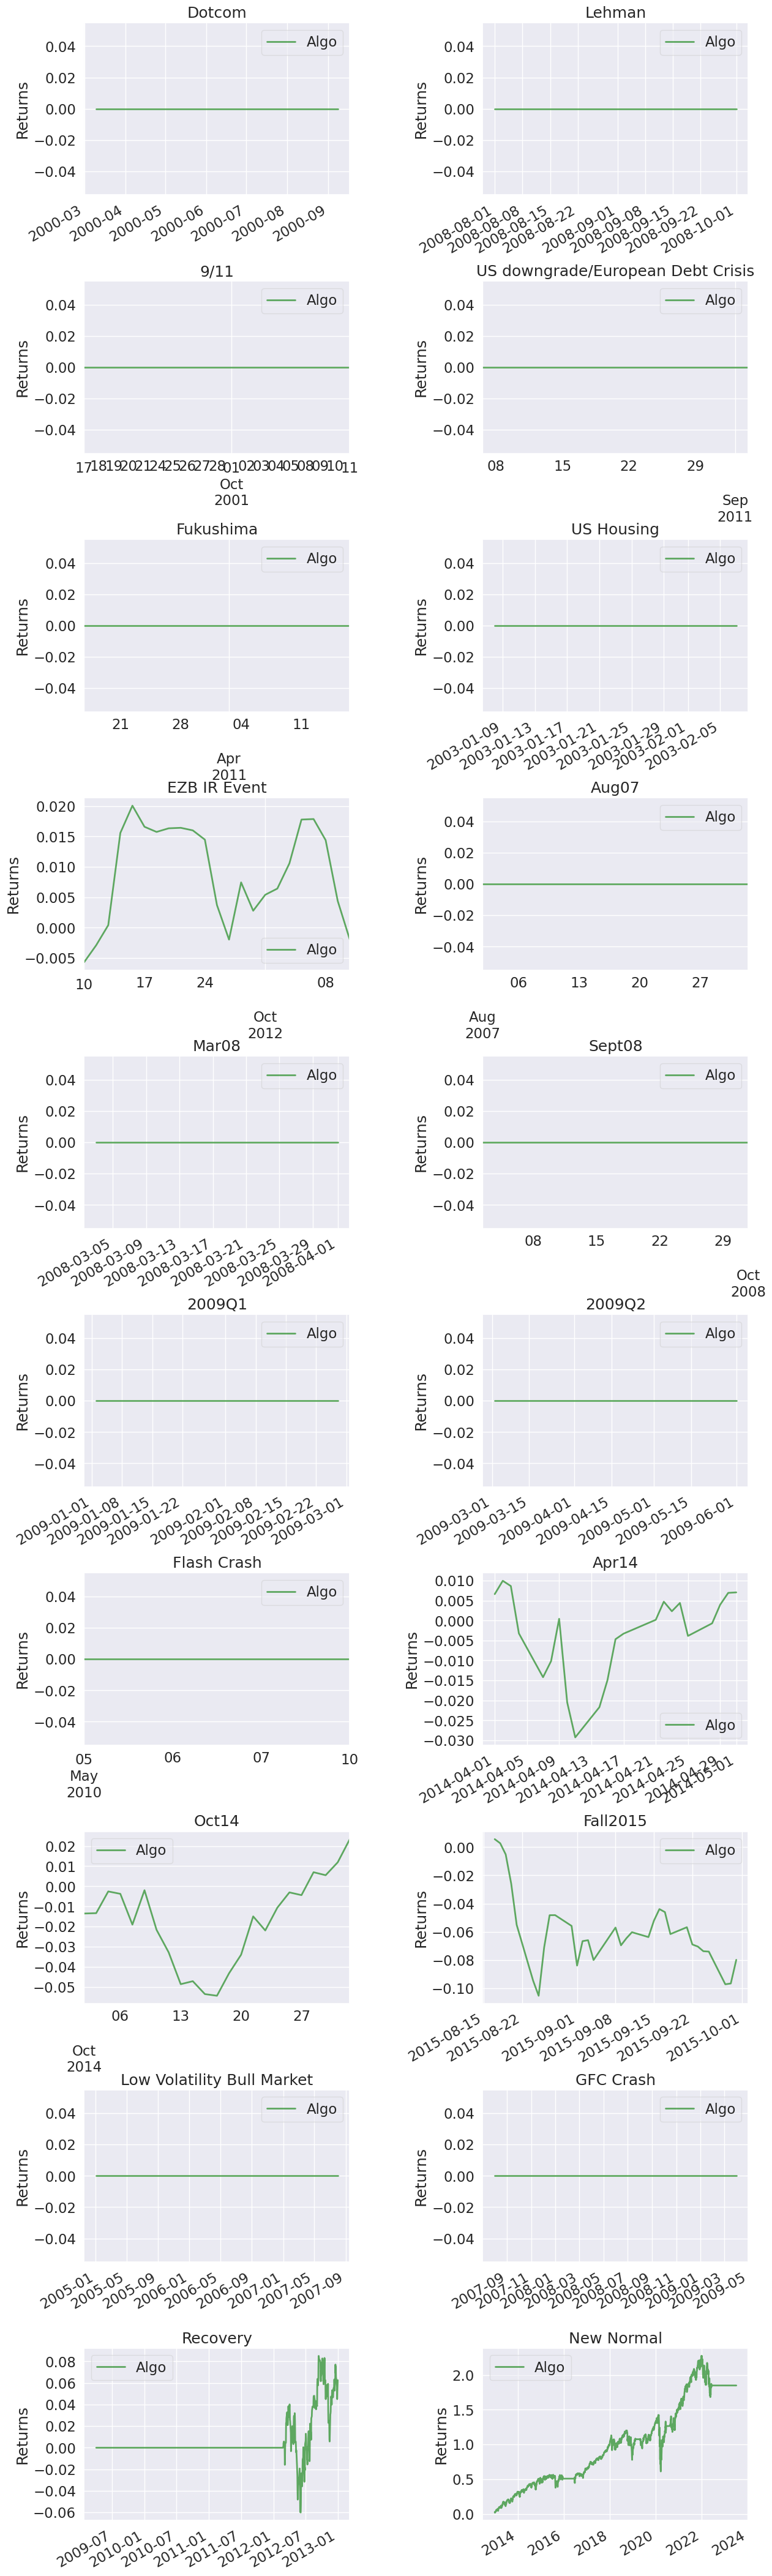

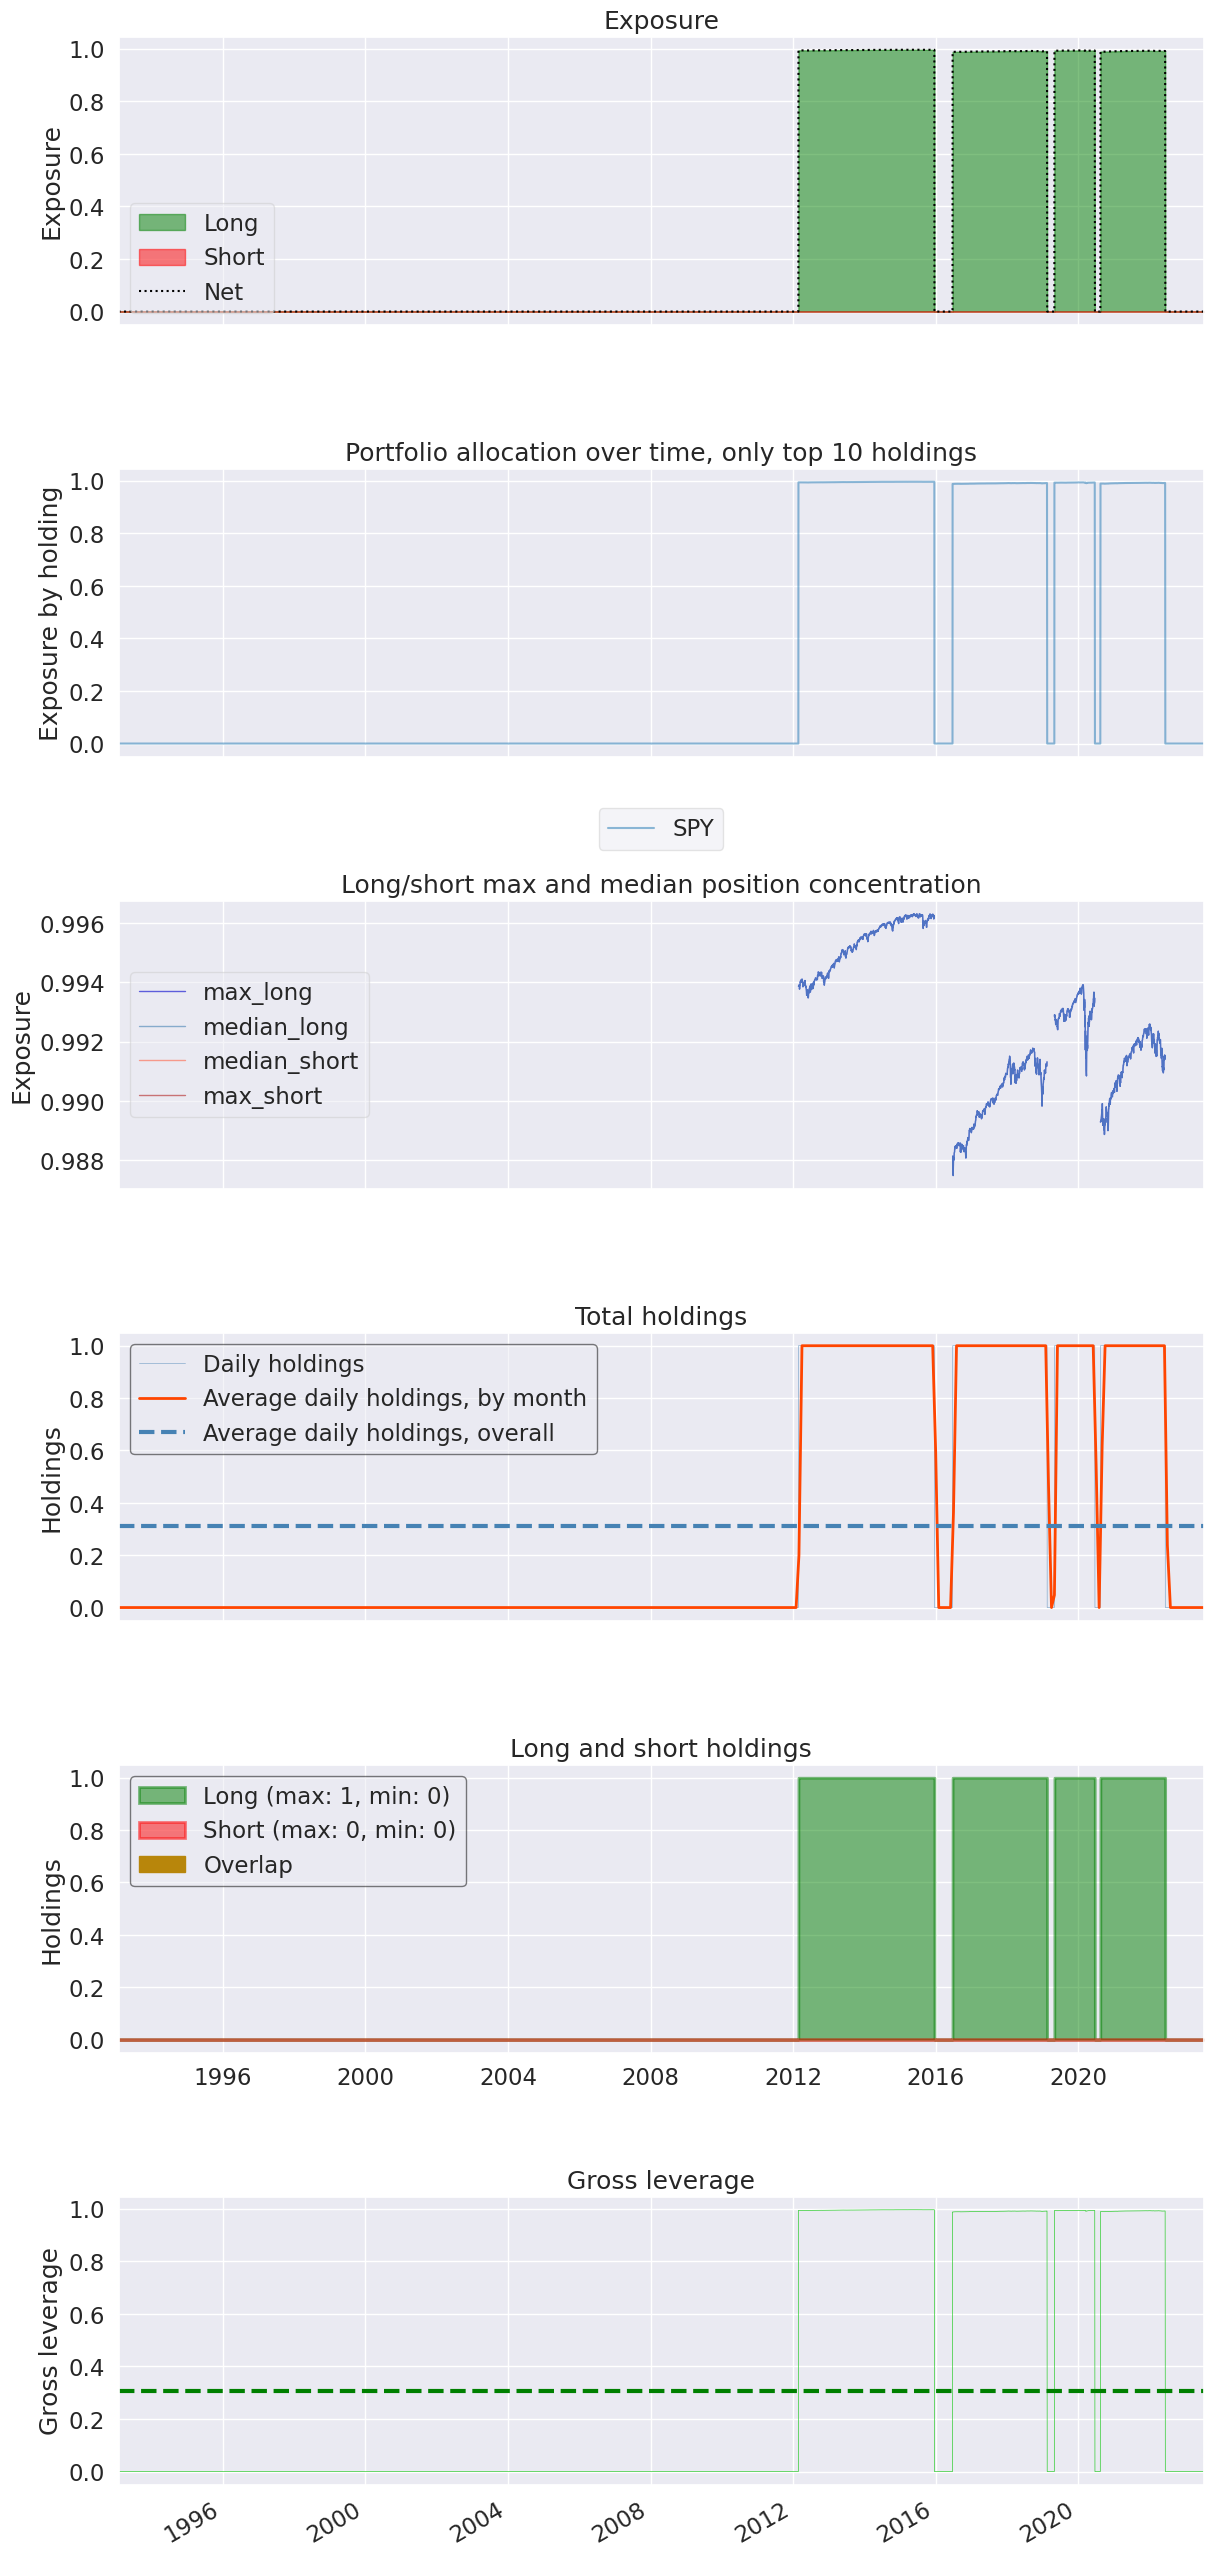

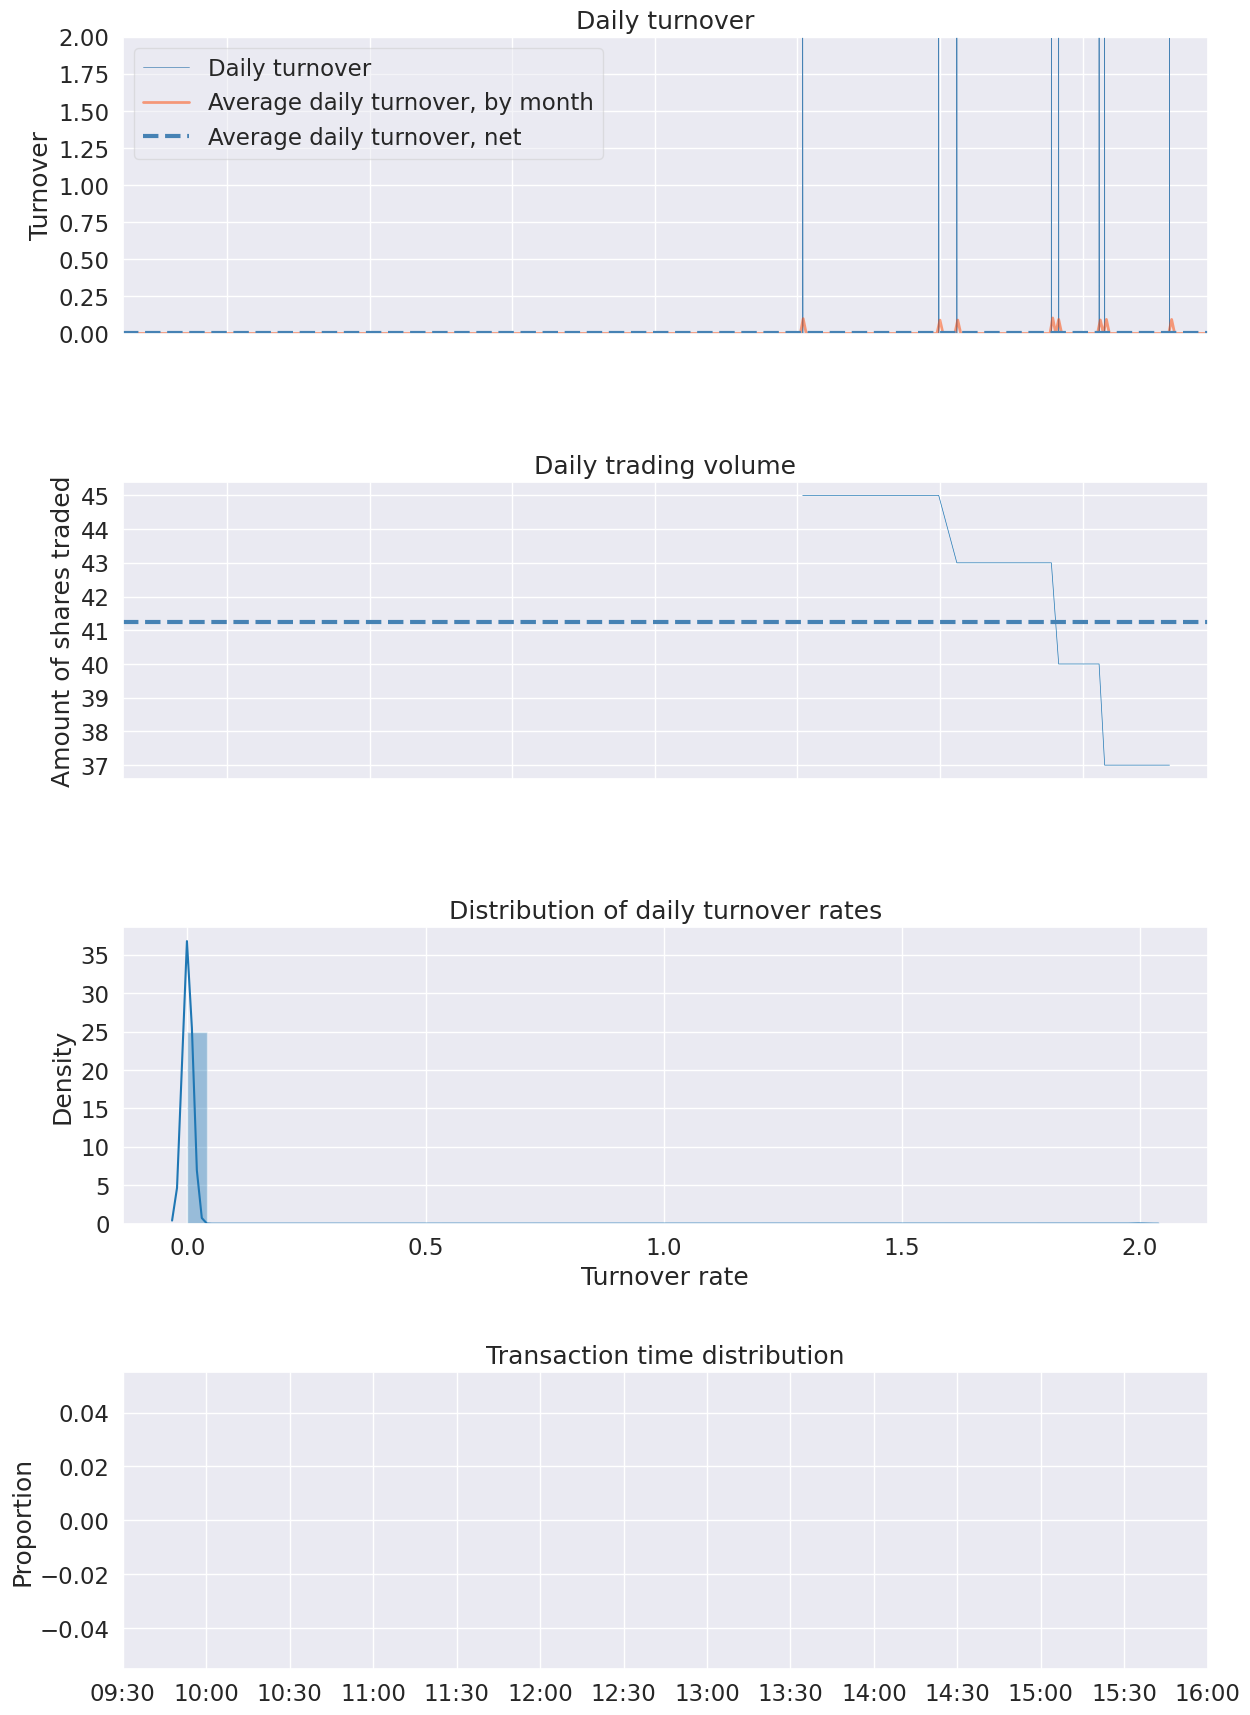

In [2]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2020-01-01',  # This date is sample specific
    round_trips=True)
